In [26]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

RANDOM_SEED = 42

In [27]:
csv_file = 'keypoints\\keypointControl_1.csv'
model_save_path = 'model\\customModel\\controlModel\\control_classifier1a.hdf5'
tflite_save_path = 'model\\customModel\\controlModel\\control_classifier1a.tflite'

In [28]:
NUM_CLASSES = 2
num_identifier_columns = 1
coord_dimensions = 3

In [29]:
# lst = [1] + list(range(num_identifier_columns, (21 * 2) + num_identifier_columns))
lst = list(range(num_identifier_columns, 21 * coord_dimensions + num_identifier_columns + 1))
X_dataset = np.loadtxt(csv_file, delimiter=',', dtype='float32', usecols=lst)

In [30]:
y_dataset = np.loadtxt(csv_file, delimiter=',', dtype='<U8', usecols=0)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)

In [32]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target data to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * coord_dimensions + 1, )),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [34]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 40)                2600      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                                 
Total params: 3,462
Trainable params: 3,462
Non-trainable params: 0
_________________________________________________________________


In [35]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

In [36]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
model.fit(
    X_train,
    y_train_encoded,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test_encoded),
    callbacks=[es_callback]    # callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
8/8 [==============================] - 2s 44ms/step - loss: 0.6113 - accuracy: 0.7703 - val_loss: 0.5100 - val_accuracy: 0.9000
Epoch 2/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.4538 - accuracy: 0.9188 - val_loss: 0.3929 - val_accuracy: 0.9040
Epoch 3/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.3423 - accuracy: 0.9208 - val_loss: 0.3145 - val_accuracy: 0.9040
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.2694 - accuracy: 0.9218 - val_loss: 0.2755 - val_accuracy: 0.9040
Epoch 5/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.2374 - accuracy: 0.9218 - val_loss: 0.2581 - val_accuracy: 0.9040
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.2212 - accuracy: 0.9218 - val_loss: 0.2436 - val_accuracy: 0.9040
Epoch 7/1000
8/8 [==============================] - 0s 6ms/step - loss: 0.2056 - accuracy: 0.9218 - val_loss: 0.2284 - val_accuracy: 0.9040
Epoch 8/1000
8/8 [=

In [38]:
val_loss, val_acc = model.evaluate(X_test, y_test_encoded, batch_size=128)

2/2 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 0.9960


In [39]:
# model = tf.keras.models.load_model(model_save_path)

In [40]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 88ms/step
[5.986348e-16 1.000000e+00]
1


8/8 [==============================] - 0s 1ms/step


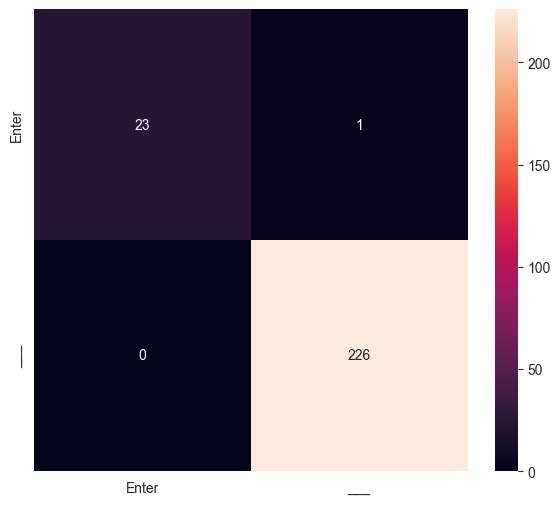

Classification Report
              precision    recall  f1-score   support

       Enter       1.00      0.96      0.98        24
         ___       1.00      1.00      1.00       226

    accuracy                           1.00       250
   macro avg       1.00      0.98      0.99       250
weighted avg       1.00      1.00      1.00       250


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

label_encoder.fit(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

print_confusion_matrix(y_test_decoded, y_pred_decoded)

# Tensorflow-Lite

In [42]:
model.save(model_save_path, include_optimizer=False)

In [43]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmpctrbn1km\assets


INFO:tensorflow:Assets written to: C:\Users\ivono\AppData\Local\Temp\tmpctrbn1km\assets


8360

In [44]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [45]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [46]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [47]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 4 ms


In [48]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.7799003e-16 1.0000000e+00]
1
